In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import utils

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [3]:
# Change the following data folders
data_dir = r'D:\OldNew\3DVC\pose-estimation'
training_data_all_dir = data_dir + '/training_data'
training_data_dir = training_data_all_dir + "/data"
split_dir = training_data_all_dir + "/splits"

In [4]:
def get_split_files(split_name):
    with open(os.path.join(split_dir, f"{split_name}.txt"), 'r') as f:
        prefix = [os.path.join(training_data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta

In [20]:
rgb_files, depth_files, label_files, meta_files = get_split_files('val')
print(rgb_files[10])

D:\OldNew\3DVC\pose-estimation/training_data/data\1-15-34_color_kinect.png


In [6]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

## Get familiar with the data

[2023-06-10 18:02:08] [DEBUG] STREAM b'IHDR' 16 13
[2023-06-10 18:02:08] [DEBUG] STREAM b'IDAT' 41 8192
[2023-06-10 18:02:08] [DEBUG] STREAM b'IHDR' 16 13
[2023-06-10 18:02:08] [DEBUG] STREAM b'IDAT' 41 8192
[2023-06-10 18:02:08] [DEBUG] STREAM b'IHDR' 16 13
[2023-06-10 18:02:08] [DEBUG] STREAM b'IDAT' 41 7722
[2023-06-10 18:02:08] [DEBUG] STREAM b'IHDR' 16 13
[2023-06-10 18:02:08] [DEBUG] STREAM b'IDAT' 41 8192


<PIL.PngImagePlugin.PngImageFile image mode=I size=1280x720 at 0x27A8EB43A30>
[[6.007 6.003 5.999 ... 3.203 3.202 3.201]
 [5.975 5.971 5.967 ... 3.194 3.193 3.192]
 [5.944 5.94  5.936 ... 3.185 3.184 3.183]
 ...
 [1.251 1.25  1.25  ... 1.058 1.058 1.057]
 [1.249 1.249 1.249 ... 1.057 1.057 1.056]
 [1.248 1.248 1.247 ... 1.056 1.056 1.056]]


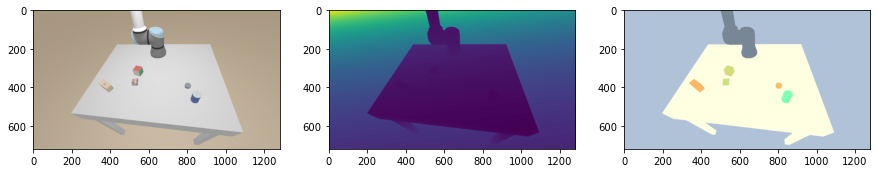

In [22]:
rgb = np.array(Image.open(rgb_files[10])) / 255   # convert 0-255 to 0-1
depth = np.array(Image.open(depth_files[10])) / 1000   # convert from mm to m
label = np.array(Image.open(label_files[10]))
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

print(Image.open(depth_files[10]))
print(depth)

In [8]:
meta = load_pickle(meta_files[10])
meta.keys()

dict_keys(['poses_world', 'extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])

In [9]:
meta['object_names'], meta['object_ids']

(['master_chef_can',
  'pudding_box',
  'rubiks_cube',
  'tuna_fish_can',
  'wood_block'],
 array([39, 51, 52, 57, 58], dtype=int64))

In [10]:
poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])

## Lift depth to point cloud

In [19]:
intrinsic = meta['intrinsic']
z = depth
print(z)
v, u = np.indices(z.shape)
uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
# print(points_viewer)

[[6.007 6.003 5.999 ... 3.203 3.202 3.201]
 [5.975 5.971 5.967 ... 3.194 3.193 3.192]
 [5.944 5.94  5.936 ... 3.185 3.184 3.183]
 ...
 [1.251 1.25  1.25  ... 1.058 1.058 1.057]
 [1.249 1.249 1.249 ... 1.057 1.057 1.056]
 [1.248 1.248 1.247 ... 1.056 1.056 1.056]]


In [17]:
import open3d
points = open3d.utility.Vector3dVector(points_viewer.reshape([-1, 3]))
colors = open3d.utility.Vector3dVector(rgb.reshape([-1, 3]))
pcd = open3d.geometry.PointCloud()
pcd.points = points
pcd.colors = colors
open3d.visualization.draw_geometries([pcd])
# will open another window to show the point cloud

## Draw bounding boxes of poses on 2D image
If you are curious, take a look at `utils.py`. It is very simple.

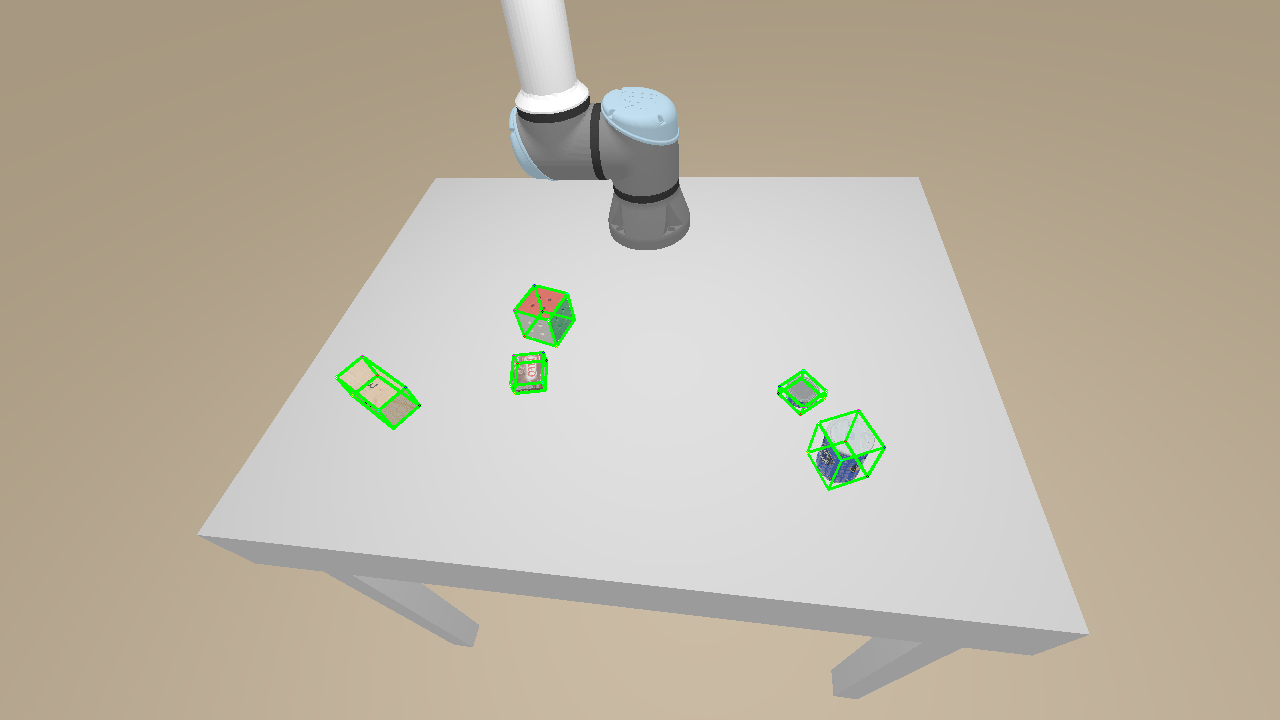

In [13]:
boxed_image = np.array(rgb)
for i in range(len(poses_world)):
    utils.draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2)

Image.fromarray((boxed_image * 255).astype(np.uint8))

## Testing data
Testing data has everything but the poses.

In [14]:
load_pickle(data_dir + "/testing_data/data/1-2-11_meta.pkl").keys()

dict_keys(['extents', 'scales', 'object_ids', 'object_names', 'extrinsic', 'intrinsic'])

[2023-06-10 17:21:14] [DEBUG] STREAM b'IHDR' 16 13
[2023-06-10 17:21:14] [DEBUG] STREAM b'IDAT' 41 8192


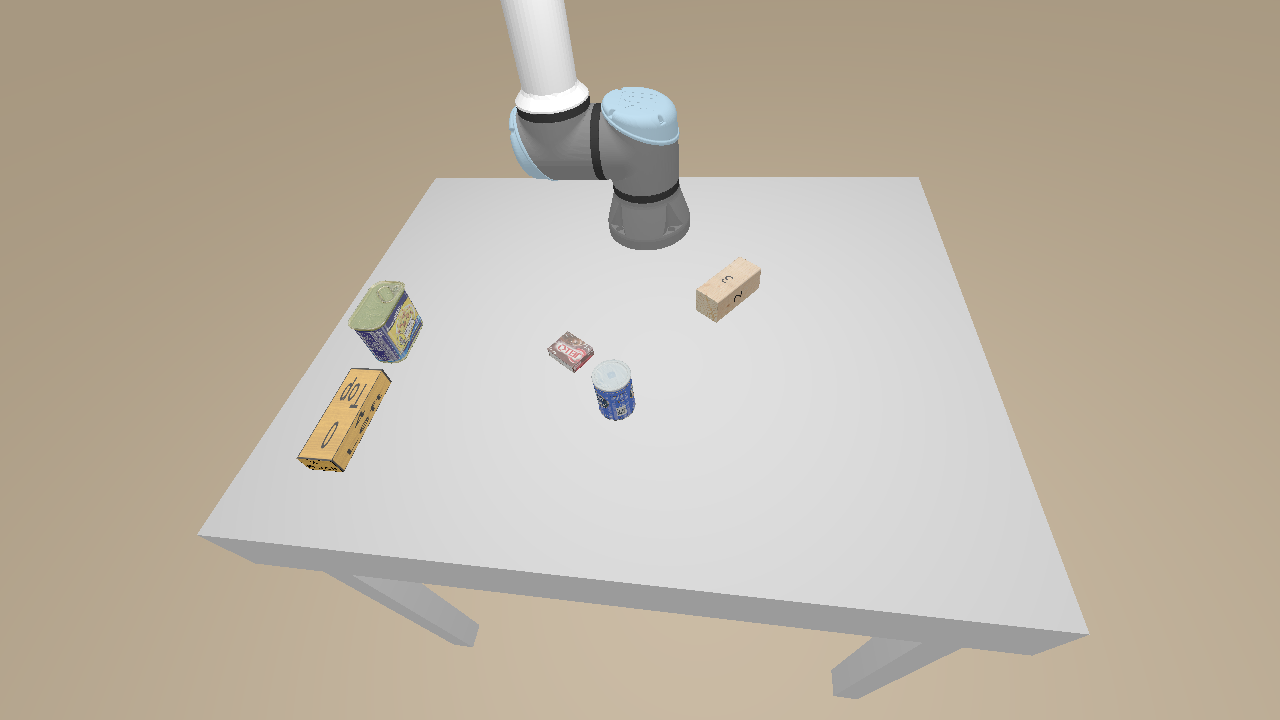

In [15]:
Image.open(data_dir + "/testing_data/data/1-2-11_color_kinect.png")